# Import Library

In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Visuzliation Setting
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
from matplotlib import colors
import seaborn as sns

---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
root = os.path.join(os.getcwd(), 'DATA')

# Training Data
빅콘테스트 제공 데이터 전처리

## Import Data

In [4]:
df_raw = pd.read_excel(os.path.join(root, 'train.xlsx'))
df_train = df_raw.copy()

### Add Columns

In [5]:
# 날짜변수 추가
df_train['year'] = df_train['REG_DATE'].dt.year
df_train['month'] = df_train['REG_DATE'].dt.month
df_train['day'] = df_train['REG_DATE'].dt.day

In [6]:
df_train['VALUE_COUNT'] = 0;
value_dict = {}
for name, value in zip(df_train['P_NAME'].value_counts().index,df_train['P_NAME'].value_counts()):
    value_dict[name] = value

def value(col):
    return value_dict[col]

df_train['VALUE_COUNT'] = df_train['P_NAME'].apply(value)

### One hot encoding
P_IMPORT_TYPE 이라는 특수한 컬럼에 대한 전처리

In [7]:
import_type_list = set()
for tmp in df_train.P_IMPORT_TYPE.unique():
    for a in tmp.split(','):
        import_type_list.add(a)

In [8]:
for name in import_type_list:
    df_train[name] = 0
    df_train.loc[df_train['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

---

# Weather data

## Import Data

In [9]:
df_weather_code = pd.read_csv(os.path.join(root, 'raw_weather_code.csv'), header=None, index_col=0)

In [10]:
weather_list = [pd.read_csv(os.path.join(root, 'raw_weather_20151228_20161227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20161228_20171227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20171228_20181227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20181228_20191227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20191228_20201227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20201228_20210818.csv'), encoding='euc-kr')]


## Preprocess
- '지점'에 따른 나라명 컬럼 (country) 추가
- 각 나라, 일자 별로 평균 강수량, 풍속, 기온 계산

In [11]:
# 지점에 따라 나라명 추가
def set_country(row):
    data = df_weather_code[df_weather_code[1] == row['지점']]
    if data.empty:
        return ""
    return data.iloc[0][2]


def preprocess_weather(df_weather):
    # 날짜 정보 정리
    df_weather['year'] = df_weather['일시'].astype('str').str[:4].astype('int')
    df_weather['month'] = df_weather['일시'].astype('str').str[5:7].astype('int')
    df_weather['day'] = df_weather['일시'].astype('str').str[8:10].astype('int')
    # 1차 평균
    df_weather['rain'] = df_weather[['지점', 'year', 'month', 'day', '강수량']].groupby(['지점', 'year', 'month', 'day']).transform('mean')
    df_weather['wind'] = df_weather[['지점', 'year', 'month', 'day', '풍속']].groupby(['지점', 'year', 'month', 'day']).transform('mean')
    df_weather['temperature'] = df_weather[['지점', 'year', 'month', 'day', '기온']].groupby(['지점', 'year', 'month', 'day']).transform('mean')
    # 컬럼/행 정리
    df_weather.drop(columns = ['지점명', '일시', '강수량', '풍속', '기온'], inplace=True)
    df_weather.drop_duplicates(inplace=True)
    # 나라명 추가
    df_weather['CTRY_1'] = ""
    for i, row in df_weather.iterrows():
        df_weather.at[i, 'CTRY_1'] = set_country(row)
    # 2차 평균
    df_weather['rain'] = df_weather[['CTRY_1', 'year', 'month', 'day', 'rain']].groupby(['CTRY_1', 'year', 'month', 'day']).transform('mean')
    df_weather['wind'] = df_weather[['CTRY_1', 'year', 'month', 'day', 'wind']].groupby(['CTRY_1', 'year', 'month', 'day']).transform('mean')
    df_weather['temperature'] = df_weather[['CTRY_1', 'year', 'month', 'day', 'temperature']].groupby(['CTRY_1', 'year', 'month', 'day']).transform('mean')
    # 컬럼/행 정리
    df_weather.drop(columns = ['지점'], inplace=True)
    df_weather.drop_duplicates(inplace=True)
    # 인덱스 정리
    df_weather.reset_index(drop=True, inplace=True)

In [12]:
for df in weather_list:
    preprocess_weather(df)
df_weather = pd.concat(weather_list)

In [13]:
df_weather = pd.concat(weather_list)

In [14]:
df_weather.describe()

,year,month,day,rain,wind,temperature
count,2061.000000,2061.000000,2061.000000,2061.000000,2061.000000,2061.000000
mean,2018.328967,6.287239,15.699660,-23.278104,2.998296,14.269720
std,1.640057,3.410574,8.807573,56.267705,1.794841,5.851843
min,2015.000000,1.000000,1.000000,-653.797980,-18.724456,-0.011721
25%,2017.000000,3.000000,8.000000,-22.655000,3.042996,8.934369
50%,2018.000000,6.000000,16.000000,-1.617694,3.283647,14.834837
75%,2020.000000,9.000000,23.000000,2.667105,3.547470,19.677071
max,2021.000000,12.000000,31.000000,24.875000,5.503693,23.728066


#### 확인필요
- outlier 찾아내기 > 값이 너무 크거나 작은 경우 제외
- 날짜별로 확인 후 비어있는 값 채워넣기 (전/다음날 이용)
    - 13947개 데이터 중 rain, wind, temperature 갯수 보면 몇개 비어있는지 확인 가능
- 합치기..
- 강수량의 경우 NaN 값이 너무 많음
    - 위 전처리들을 한 후에도 많다면 사용불가
    - 위 전처리 후에는 적다면 전날/다음날 데이터 기반으로 채워넣기 진행

## Version 2

### Import Data

In [15]:
rwt_20152016 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20151228_20161227.csv',encoding='cp949') 
rwt_20162017 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20161228_20171227.csv',encoding='cp949') 
rwt_20172018 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20171228_20181227.csv',encoding='cp949') 
rwt_20182019 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20181228_20191227.csv',encoding='cp949') 
rwt_20192020 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20191228_20201227.csv',encoding='cp949') 
rwt_20202021 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20201228_20210818.csv',encoding='cp949') 

### Merge

In [16]:
rwt = pd.merge(rwt_20152016,rwt_20162017,how='outer')

rwt = rwt.append(rwt_20172018)
rwt = rwt.append(rwt_20182019)
rwt = rwt.append(rwt_20192020)
rwt = rwt.append(rwt_20202021)

rwt # 국가별 강수량,풍속,기온 데이터

,지점,지점명,일시,풍속,강수량,기온
0,1001,얀마이엔,2015-12-28 03:00,11.0,NaN,2.3
1,1001,얀마이엔,2015-12-28 06:00,13.0,0.0,2.6
2,1001,얀마이엔,2015-12-28 09:00,11.0,NaN,3.3
3,1001,얀마이엔,2015-12-28 12:00,13.0,0.1,3.4
4,1001,얀마이엔,2015-12-28 15:00,15.0,NaN,3.7
...,...,...,...,...,...,...
130209,85934,푼타아레나스,2021-08-17 06:00,8.0,0.0,5.3
130210,85934,푼타아레나스,2021-08-17 09:00,11.0,NaN,5.2
130211,85934,푼타아레나스,2021-08-17 12:00,12.0,1.0,4.3
130212,85934,푼타아레나스,2021-08-17 18:00,10.0,2.0,4.7


### 국가별로 나누기

#### 노르웨이 Weather

In [17]:
rwt_nor = pd.DataFrame()

for i in [1373, 1007, 1233, 1114, 1098, 1002, 1317, 1152, 1028, 1008, 1415, 1001, 1212, 1492, 1384, 1241, 1403, 1065, 1196, 1271, 1026 ,1025,1465, 1238]:
    rwt_nor = rwt_nor.append(rwt[rwt['지점']==i]) # 노르웨이

rwt_nor = rwt_nor.sort_values(by=['지점','일시'])

rwt_nor['일시'] = rwt_nor['일시'].str[:10] # 시간 부분 삭제

rwt_nor['일시'] = rwt_nor['일시'].astype('datetime64')

rwt_nor = rwt_nor.query('일시.dt.dayofweek == 0') # 일시를 일주일 간격으로 변환

rwt_nor['국가'] = '노르웨이'

rwt_nor

,지점,지점명,일시,풍속,강수량,기온,국가
0,1001,얀마이엔,2015-12-28,11.0,NaN,2.3,노르웨이
1,1001,얀마이엔,2015-12-28,13.0,0.0,2.6,노르웨이
2,1001,얀마이엔,2015-12-28,11.0,NaN,3.3,노르웨이
3,1001,얀마이엔,2015-12-28,13.0,0.1,3.4,노르웨이
4,1001,얀마이엔,2015-12-28,15.0,NaN,3.7,노르웨이
...,...,...,...,...,...,...,...
25067,1492,오슬로-블린데른,2020-06-01,3.0,NaN,12.8,노르웨이
25068,1492,오슬로-블린데른,2020-06-01,1.0,NaN,18.1,노르웨이
25069,1492,오슬로-블린데른,2020-06-01,2.0,NaN,22.9,노르웨이
25070,1492,오슬로-블린데른,2020-06-01,3.0,NaN,24.0,노르웨이


##### Preprocessing

In [18]:
rwt_nor['강수량'].isna().sum()

32300

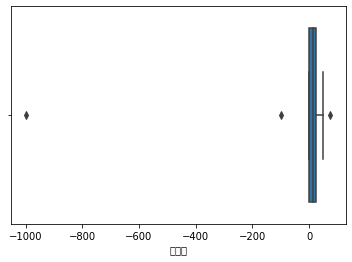

In [19]:
sns.boxplot(x = rwt_nor['강수량'].unique())
plt.xlabel('강수량')
plt.show()
# 이상치 제거 필요

In [20]:
rwt_nor[rwt_nor['강수량']<0]

,지점,지점명,일시,풍속,강수량,기온,국가
110,1001,얀마이엔,2016-01-11,8.0,-999.0,-5.7,노르웨이
390,1001,얀마이엔,2016-02-15,2.0,-99.8,-7.6,노르웨이
392,1001,얀마이엔,2016-02-15,1.0,-99.8,-6.3,노르웨이
394,1001,얀마이엔,2016-02-15,8.0,-99.8,-3.0,노르웨이
396,1001,얀마이엔,2016-02-15,3.0,-99.8,-0.8,노르웨이
...,...,...,...,...,...,...,...
61334,1492,오슬로-블린데른,2019-10-28,2.0,-999.0,7.3,노르웨이
61335,1492,오슬로-블린데른,2019-10-28,1.0,-99.8,5.6,노르웨이
24435,1492,오슬로-블린데른,2020-03-02,4.0,-99.8,3.9,노르웨이
24436,1492,오슬로-블린데른,2020-03-02,5.0,-99.8,4.4,노르웨이


In [21]:
rwt_nor = rwt_nor[(rwt_nor['강수량']>=0) | (rwt_nor['강수량'].isna())] # 강수량 음수 제거

rwt_nor

,지점,지점명,일시,풍속,강수량,기온,국가
0,1001,얀마이엔,2015-12-28,11.0,NaN,2.3,노르웨이
1,1001,얀마이엔,2015-12-28,13.0,0.0,2.6,노르웨이
2,1001,얀마이엔,2015-12-28,11.0,NaN,3.3,노르웨이
3,1001,얀마이엔,2015-12-28,13.0,0.1,3.4,노르웨이
4,1001,얀마이엔,2015-12-28,15.0,NaN,3.7,노르웨이
...,...,...,...,...,...,...,...
25067,1492,오슬로-블린데른,2020-06-01,3.0,NaN,12.8,노르웨이
25068,1492,오슬로-블린데른,2020-06-01,1.0,NaN,18.1,노르웨이
25069,1492,오슬로-블린데른,2020-06-01,2.0,NaN,22.9,노르웨이
25070,1492,오슬로-블린데른,2020-06-01,3.0,NaN,24.0,노르웨이


In [22]:
rwt_nor['풍속'].isna().sum()

327

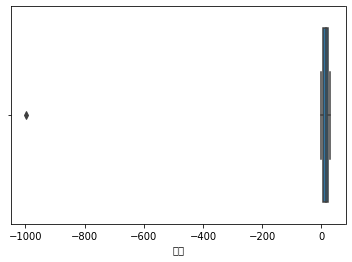

In [23]:
sns.boxplot(x = rwt_nor['풍속'].unique())
plt.xlabel('풍속')
plt.show()
# 이상치 제거 필요

In [24]:
rwt_nor[rwt_nor['풍속']<0]

,지점,지점명,일시,풍속,강수량,기온,국가
872,1001,얀마이엔,2018-04-16,-998.0,0.1,1.6,노르웨이
18969,1065,카라스요크,2018-01-29,-998.0,0.3,-19.0,노르웨이


In [25]:
rwt_nor = rwt_nor[(rwt_nor['풍속']>=0) | (rwt_nor['풍속'].isna())] # 강수량 음수 제거

rwt_nor

,지점,지점명,일시,풍속,강수량,기온,국가
0,1001,얀마이엔,2015-12-28,11.0,NaN,2.3,노르웨이
1,1001,얀마이엔,2015-12-28,13.0,0.0,2.6,노르웨이
2,1001,얀마이엔,2015-12-28,11.0,NaN,3.3,노르웨이
3,1001,얀마이엔,2015-12-28,13.0,0.1,3.4,노르웨이
4,1001,얀마이엔,2015-12-28,15.0,NaN,3.7,노르웨이
...,...,...,...,...,...,...,...
25067,1492,오슬로-블린데른,2020-06-01,3.0,NaN,12.8,노르웨이
25068,1492,오슬로-블린데른,2020-06-01,1.0,NaN,18.1,노르웨이
25069,1492,오슬로-블린데른,2020-06-01,2.0,NaN,22.9,노르웨이
25070,1492,오슬로-블린데른,2020-06-01,3.0,NaN,24.0,노르웨이


In [26]:
rwt_nor['기온'].isna().sum()

71

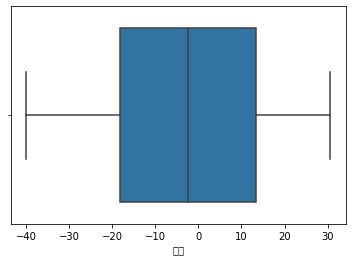

In [27]:
sns.boxplot(x = rwt_nor['기온'].unique())
plt.xlabel('기온')
plt.show()

# 노르웨이 최저기온은 영하 40도까지 내려간적 있으므로 오류값은 없는 것으로 판단

In [28]:
rwt_nor = pd.DataFrame(rwt_nor.groupby(['일시'])[['강수량','풍속','기온']].mean())

rwt_nor

,강수량,풍속,기온
일시,,,
2015-12-28,1.904762,5.264286,-3.103401
2016-01-04,0.664286,4.750000,-6.495031
2016-01-11,1.151724,5.583851,-3.889091
2016-01-18,0.934884,4.645714,-6.916477
2016-01-25,1.352174,4.857143,0.376437
...,...,...,...
2020-04-27,1.630233,3.590643,1.893296
2020-05-04,1.078571,4.689441,2.907101
2020-05-18,0.595455,3.433333,4.728346


In [29]:
rwt_nor.describe()

,강수량,풍속,기온
count,231.000000,231.000000,231.000000
mean,1.932161,4.742379,3.725899
std,1.208719,1.153567,6.116537
min,0.133333,2.719298,-8.041341
25%,1.070952,3.947098,-1.357529
50%,1.736364,4.691429,3.158427
75%,2.407143,5.366473,9.759586
max,7.274000,9.661111,17.711765


In [30]:
rwt_nor.isna().sum()

강수량    0
풍속     0
기온     0
dtype: int64

#### 베트남 Weather

In [31]:
rwt_vit = pd.DataFrame()

for i in [48914, 48808, 48870, 48877, 48845, 48840, 48887, 48917, 48820]:
    rwt_vit = rwt_vit.append(rwt[rwt['지점']==i])

rwt_vit = rwt_vit.sort_values(by=['지점명','일시'])

rwt_vit['국가'] = '베트남'

rwt_vit['일시'] = rwt_vit['일시'].str[:10] # 시간 부분 삭제

rwt_vit['일시'] = rwt_vit['일시'].astype('datetime64')

rwt_vit = rwt_vit.query('일시.dt.dayofweek == 0') # 일시를 일주일 간격으로 변환

rwt_vit # 베트남 풍속,강수량,기온

,지점,지점명,일시,풍속,강수량,기온,국가
122236,48914,까마우,2015-12-28,5.0,NaN,29.2,베트남
122237,48914,까마우,2015-12-28,5.0,NaN,30.6,베트남
122238,48914,까마우,2015-12-28,5.0,NaN,30.3,베트남
122239,48914,까마우,2015-12-28,2.0,NaN,28.2,베트남
122240,48914,까마우,2015-12-28,0.0,NaN,26.4,베트남
...,...,...,...,...,...,...,...
27303,48917,푸꾸옥,2021-08-16,0.0,NaN,27.2,베트남
27304,48917,푸꾸옥,2021-08-16,2.0,NaN,26.8,베트남
107856,48820,하노이,2016-12-12,2.0,NaN,28.0,베트남
107857,48820,하노이,2016-12-12,3.0,NaN,25.4,베트남


##### Preprocessing

In [32]:
rwt_vit['강수량'].isna().sum()

13788

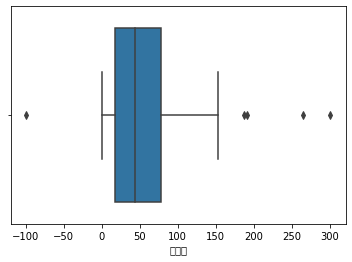

In [33]:
sns.boxplot(x = rwt_vit['강수량'].unique())
plt.xlabel('강수량')
plt.show()

# 음수인 이상치 제거 필요

In [34]:
rwt_vit[rwt_vit['강수량']<0]

,지점,지점명,일시,풍속,강수량,기온,국가
122518,48914,까마우,2016-02-01,2.0,-99.8,28.0,베트남
122625,48914,까마우,2016-02-15,1.0,-99.8,30.1,베트남
122626,48914,까마우,2016-02-15,3.0,-99.8,31.5,베트남
122627,48914,까마우,2016-02-15,3.0,-99.8,30.8,베트남
122628,48914,까마우,2016-02-15,3.0,-99.8,28.1,베트남
...,...,...,...,...,...,...,...
26181,48917,푸꾸옥,2021-02-22,5.0,-99.8,28.0,베트남
26182,48917,푸꾸옥,2021-02-22,3.0,-99.8,26.8,베트남
26183,48917,푸꾸옥,2021-02-22,0.0,-99.8,25.7,베트남
26184,48917,푸꾸옥,2021-02-22,2.0,-99.8,24.0,베트남


In [35]:
rwt_vit = rwt_vit[(rwt_vit['강수량']>=0) | (rwt_vit['강수량'].isna())] # 강수량 음수 제거

rwt_vit

,지점,지점명,일시,풍속,강수량,기온,국가
122236,48914,까마우,2015-12-28,5.0,NaN,29.2,베트남
122237,48914,까마우,2015-12-28,5.0,NaN,30.6,베트남
122238,48914,까마우,2015-12-28,5.0,NaN,30.3,베트남
122239,48914,까마우,2015-12-28,2.0,NaN,28.2,베트남
122240,48914,까마우,2015-12-28,0.0,NaN,26.4,베트남
...,...,...,...,...,...,...,...
27303,48917,푸꾸옥,2021-08-16,0.0,NaN,27.2,베트남
27304,48917,푸꾸옥,2021-08-16,2.0,NaN,26.8,베트남
107856,48820,하노이,2016-12-12,2.0,NaN,28.0,베트남
107857,48820,하노이,2016-12-12,3.0,NaN,25.4,베트남


In [36]:
rwt_vit['풍속'].isna().sum()

1

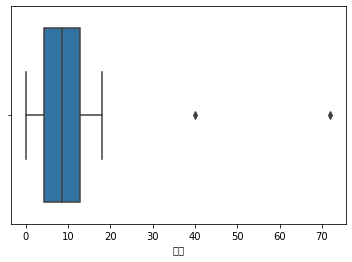

In [37]:
sns.boxplot(x = rwt_vit['풍속'].unique())
plt.xlabel('풍속')
plt.show()

In [38]:
rwt_vit['풍속'][rwt_vit['풍속']<0]

Series([], Name: 풍속, dtype: float64)

In [39]:
rwt_vit['기온'].isna().sum()

9

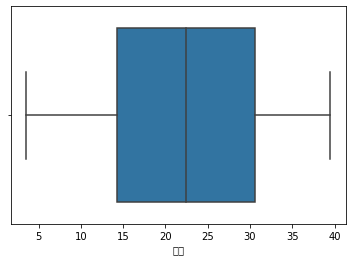

In [40]:
sns.boxplot(x = rwt_vit['기온'].unique())
plt.xlabel('기온')
plt.show()

# 이상치 없음.

In [41]:
rwt_vit2 = pd.DataFrame(rwt_vit.groupby(['일시']).mean()[['강수량','풍속','기온']])

rwt_vit2 = rwt_vit2[rwt_vit2.index<='2021-06-28']

rwt_vit2

,강수량,풍속,기온
일시,,,
2015-12-28,0.828571,2.375000,23.098214
2016-01-04,19.000000,1.666667,24.580328
2016-01-11,0.000000,2.015625,24.165625
2016-01-18,3.000000,1.822581,24.020968
2016-01-25,2.521429,3.250000,18.212500
...,...,...,...
2021-05-31,0.500000,2.156250,31.271875
2021-06-07,17.043750,2.078125,28.542188
2021-06-14,3.080000,2.234375,29.495313


In [42]:
rwt_vit2.describe()

,강수량,풍속,기온
count,273.000000,288.000000,288.000000
mean,7.190637,2.119864,26.465741
std,7.661904,0.414989,2.839870
min,0.000000,0.647059,17.800000
25%,1.000000,1.858817,24.403084
50%,4.736364,2.078125,26.842169
75%,10.554545,2.355932,28.883946
max,40.572222,3.546875,31.271875


In [43]:
rwt_vit2.isna().sum()

강수량    15
풍속      0
기온      0
dtype: int64

In [44]:
rwt_vit2[rwt_vit2['강수량'].isna()] # 해당 월 평균 강수량 데이터로 결측값 대치해보자! 

,강수량,풍속,기온
일시,,,
2016-02-08,NaN,2.355932,19.338596
2016-02-29,NaN,2.946429,22.907143
2017-02-06,NaN,2.343750,23.735938
2017-12-18,NaN,2.921875,20.045313
2018-02-05,NaN,3.125000,19.448437
2018-04-02,NaN,2.156250,25.909375
2018-04-09,NaN,2.269841,25.173016
2019-01-28,NaN,2.031250,23.398438
2019-02-04,NaN,2.609375,25.159375


In [45]:
rwt_vit2['일시'] = rwt_vit2.index
rwt_vit2['일시'] = rwt_vit2['일시'].astype('string')

rain_1602 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2016-02')].mean()['강수량']) # 2016년 2월 강수량 평균
rain_1702 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2017-02')].mean()['강수량']) # 2017년 2월 강수량 평균
rain_1712 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2017-12')].mean()['강수량']) # 2017년 12월 강수량 평균
rain_1802 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2018-02')].mean()['강수량']) # 2018년 2월 강수량 평균
rain_1804 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2018-04')].mean()['강수량']) # 2018년 4월 강수량 평균
rain_1901 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2019-01')].mean()['강수량']) # 2019년 1월 강수량 평균
rain_1902 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2019-02')].mean()['강수량']) # 2019년 2월 강수량 평균
rain_1912 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2019-12')].mean()['강수량']) # 2019년 12월 강수량 평균
rain_2003 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2020-03')].mean()['강수량']) # 2020년 3월 강수량 평균
rain_2004 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2020-04')].mean()['강수량']) # 2020년 4월 강수량 평균
rain_2102 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2021-02')].mean()['강수량']) # 2021년 2월 강수량 평균
rain_2103 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2021-03')].mean()['강수량']) # 2021년 3월 강수량 평균

In [46]:
rwt_vit2[rwt_vit2['일시'].str.contains('2016-02')]['강수량'].fillna(rain_1602) # 2016년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2017-02')]['강수량'].fillna(rain_1702) # 2017년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2017-12')]['강수량'].fillna(rain_1712) # 2017년 12월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2018-02')]['강수량'].fillna(rain_1802) # 2018년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2018-04')]['강수량'].fillna(rain_1804) # 2018년 4월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2019-01')]['강수량'].fillna(rain_1901) # 2019년 1월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2019-02')]['강수량'].fillna(rain_1902) # 2019년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2019-12')]['강수량'].fillna(rain_1912) # 2019년 12월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2020-03')]['강수량'].fillna(rain_2003) # 2020년 3월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2020-04')]['강수량'].fillna(rain_2004) # 2020년 4월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2021-02')]['강수량'].fillna(rain_2102) # 2021년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2021-03')]['강수량'].fillna(rain_2103) # 2021년 3월 강수량 평균으로 결측값 대치

rwt_vit2.isna().sum()

강수량    15
풍속      0
기온      0
일시      0
dtype: int64

#### 중국 Weather

In [47]:
data = pd.read_csv(os.path.join(root, 'raw_weather_china.csv'),encoding='cp949')

data

,Unnamed: 0,지점,지점명,일시,풍속,강수량,기온
0,127994,50527,하일라르,2015-12-28 03:00,2.0,NaN,-28.8
1,127995,50527,하일라르,2015-12-28 06:00,2.0,NaN,-24.2
2,127996,50527,하일라르,2015-12-28 09:00,4.0,NaN,-26.6
3,127997,50527,하일라르,2015-12-28 12:00,3.0,NaN,-25.3
4,127998,50527,하일라르,2015-12-28 15:00,6.0,NaN,-29.5
...,...,...,...,...,...,...,...
1115542,106881,59981,시사다오,2021-08-17 12:00,1.0,NaN,28.8
1115543,106882,59981,시사다오,2021-08-17 15:00,1.0,NaN,28.3
1115544,106883,59981,시사다오,2021-08-17 18:00,0.0,NaN,27.6
1115545,106884,59981,시사다오,2021-08-17 21:00,2.0,NaN,27.8


In [48]:
data['일시'] = data['일시'].astype('string')

data['일시'] = data['일시'].str[:10]

data['일시'] = data['일시'].astype('datetime64')

data = data.query('일시.dt.dayofweek == 0')

data['국가'] = '중국'

data # 중국 일주일간 rwt 데이터

,Unnamed: 0,지점,지점명,일시,풍속,강수량,기온,국가
0,127994,50527,하일라르,2015-12-28,2.0,NaN,-28.8,중국
1,127995,50527,하일라르,2015-12-28,2.0,NaN,-24.2,중국
2,127996,50527,하일라르,2015-12-28,4.0,NaN,-26.6,중국
3,127997,50527,하일라르,2015-12-28,3.0,NaN,-25.3,중국
4,127998,50527,하일라르,2015-12-28,6.0,NaN,-29.5,중국
...,...,...,...,...,...,...,...,...
1115533,106872,59981,시사다오,2021-08-16,2.0,NaN,31.4,중국
1115534,106873,59981,시사다오,2021-08-16,1.0,NaN,29.0,중국
1115535,106874,59981,시사다오,2021-08-16,3.0,NaN,28.5,중국
1115536,106875,59981,시사다오,2021-08-16,1.0,NaN,27.8,중국


In [49]:
data = data[data['일시']<='2021-06-28']

data = data.iloc[:,1:]

data

,지점,지점명,일시,풍속,강수량,기온,국가
0,50527,하일라르,2015-12-28,2.0,NaN,-28.8,중국
1,50527,하일라르,2015-12-28,2.0,NaN,-24.2,중국
2,50527,하일라르,2015-12-28,4.0,NaN,-26.6,중국
3,50527,하일라르,2015-12-28,3.0,NaN,-25.3,중국
4,50527,하일라르,2015-12-28,6.0,NaN,-29.5,중국
...,...,...,...,...,...,...,...
1115148,59981,시사다오,2021-06-28,7.0,NaN,30.8,중국
1115149,59981,시사다오,2021-06-28,4.0,NaN,29.5,중국
1115150,59981,시사다오,2021-06-28,3.0,NaN,29.2,중국
1115151,59981,시사다오,2021-06-28,6.0,NaN,29.2,중국


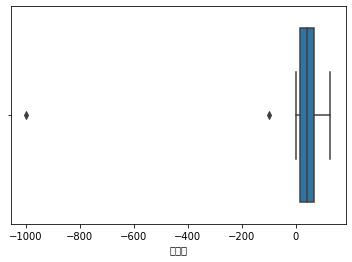

In [50]:
sns.boxplot(data['강수량'].unique())
plt.xlabel('강수량')
plt.show()

In [51]:
data[data['강수량']<0] # 2% 비율이고 값을 알 수 없으므로 drop하기

,지점,지점명,일시,풍속,강수량,기온,국가
389,50527,하일라르,2016-02-15,3.0,-99.8,-16.6,중국
391,50527,하일라르,2016-02-15,4.0,-99.8,-14.5,중국
393,50527,하일라르,2016-02-15,5.0,-99.8,-19.1,중국
394,50527,하일라르,2016-02-15,3.0,-99.8,-18.0,중국
395,50527,하일라르,2016-02-15,3.0,-99.8,-18.2,중국
...,...,...,...,...,...,...,...
1100479,58027,쉬저우,2021-02-08,3.0,-999.0,1.6,중국
1101579,58238,난징,2021-04-19,5.0,-999.0,14.9,중국
1105478,58666,다천다오,2021-02-08,10.0,-999.0,7.3,중국
1113583,59948,야샨,2021-02-08,8.0,-999.0,19.2,중국


In [52]:
data = data[(data['강수량']>=0) | (data['강수량'].isna())] # 강수량 음수 제거

data

,지점,지점명,일시,풍속,강수량,기온,국가
0,50527,하일라르,2015-12-28,2.0,NaN,-28.8,중국
1,50527,하일라르,2015-12-28,2.0,NaN,-24.2,중국
2,50527,하일라르,2015-12-28,4.0,NaN,-26.6,중국
3,50527,하일라르,2015-12-28,3.0,NaN,-25.3,중국
4,50527,하일라르,2015-12-28,6.0,NaN,-29.5,중국
...,...,...,...,...,...,...,...
1115148,59981,시사다오,2021-06-28,7.0,NaN,30.8,중국
1115149,59981,시사다오,2021-06-28,4.0,NaN,29.5,중국
1115150,59981,시사다오,2021-06-28,3.0,NaN,29.2,중국
1115151,59981,시사다오,2021-06-28,6.0,NaN,29.2,중국


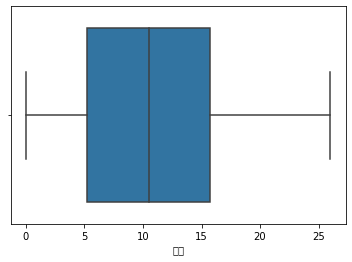

In [53]:
sns.boxplot(data['풍속'].unique())
plt.xlabel('풍속')
plt.show()

# 이상치 없음.

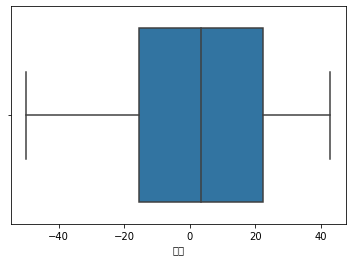

In [54]:
sns.boxplot(data['기온'].unique())
plt.xlabel('기온')
plt.show()

# 이상치 없음.

In [55]:
chn_rwt = pd.DataFrame(data.groupby('일시').mean())

chn_rwt = chn_rwt[['풍속','강수량','기온']]

chn_rwt

,풍속,강수량,기온
일시,,,
2015-12-28,2.338129,0.708333,-0.262050
2016-01-04,2.358491,2.372093,0.026772
2016-01-11,2.552050,1.794366,-2.603943
2016-01-18,2.481132,1.052778,-3.982704
2016-01-25,2.214173,0.525000,-6.559213
...,...,...,...
2021-05-31,2.718799,5.530818,20.851501
2021-06-07,2.575277,6.135652,22.328051
2021-06-14,2.808847,6.745064,22.666352


In [56]:
chn_rwt.describe()

,풍속,강수량,기온
count,288.000000,287.000000,288.000000
mean,2.441163,3.006765,12.015510
std,0.286882,2.139905,9.517001
min,1.771739,0.033333,-6.559213
25%,2.250591,1.510653,3.128850
50%,2.406681,2.604167,13.320644
75%,2.593325,4.041554,21.004752
max,4.026316,12.142105,26.110147


In [57]:
chn_rwt.isna().sum()

풍속     0
강수량    1
기온     0
dtype: int64

In [58]:
chn_rwt['일시'] = chn_rwt.index

chn_rwt

,풍속,강수량,기온,일시
일시,,,,
2015-12-28,2.338129,0.708333,-0.262050,2015-12-28
2016-01-04,2.358491,2.372093,0.026772,2016-01-04
2016-01-11,2.552050,1.794366,-2.603943,2016-01-11
2016-01-18,2.481132,1.052778,-3.982704,2016-01-18
2016-01-25,2.214173,0.525000,-6.559213,2016-01-25
...,...,...,...,...
2021-05-31,2.718799,5.530818,20.851501,2021-05-31
2021-06-07,2.575277,6.135652,22.328051,2021-06-07
2021-06-14,2.808847,6.745064,22.666352,2021-06-14


In [59]:
chn_rwt['일시'] = chn_rwt['일시'].astype('string')

rain_2102 = chn_rwt[chn_rwt['일시'].str.contains('2021-02')].mean()['강수량']  # 2021년 2월 강수량 평균

chn_rwt = chn_rwt.fillna(rain_2102)  # 2021년 2월 강수량 평균으로 결측값 대치

chn_rwt.isna().sum()

풍속     0
강수량    0
기온     0
일시     0
dtype: int64

In [60]:
chn_rwt.drop('일시',axis=1,inplace=True)

chn_rwt

,풍속,강수량,기온
일시,,,
2015-12-28,2.338129,0.708333,-0.262050
2016-01-04,2.358491,2.372093,0.026772
2016-01-11,2.552050,1.794366,-2.603943
2016-01-18,2.481132,1.052778,-3.982704
2016-01-25,2.214173,0.525000,-6.559213
...,...,...,...
2021-05-31,2.718799,5.530818,20.851501
2021-06-07,2.575277,6.135652,22.328051
2021-06-14,2.808847,6.745064,22.666352


## Add to Training Data

In [61]:
df_train = pd.merge(df_train, df_weather, how='left', on=['year', 'month', 'day', 'CTRY_1'])

In [62]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

,REG_DATE,P_TYPE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,P_PRICE,year,month,day,VALUE_COUNT,꼬리_외화획득용,절단,자숙,머리,냉장,알,동체,다리,필렛(F),내장,지느러미,볼살,머리_외화획득용,목살,한쪽껍질붙은,집게다리,창난,캐비아대용,껍질,외투막,개아지살,살,줄기,머리살,턱살,건조,활,포장횟감,냉동,슬라이스(S),곤이,눈살,횟감,훈제,염장,난포선,간,rain,wind,temperature
35190,2019-05-06,수산물,대만,대만,판매용,어류,상어 고래,청상아리,냉동,2.856699,2019,5,6,148,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN
21620,2018-01-29,수산물,캐나다,캐나다,판매용,알 곤이류,성게알,성게알,"냉장,횟감",111.250000,2018,1,29,453,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN
37400,2019-07-22,수산물,중국,중국,판매용,어류,민어 점성어,민어,냉동,3.746992,2019,7,22,109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN
22803,2018-03-05,수산물,태국,태국,판매용,연체류 해물모듬,갑오징어,갑오징어,냉장,9.978960,2018,3,5,783,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
19519,2017-11-20,수산물,태국,태국,판매용,갑각류,새우,흰다리새우,"냉동,살,자숙",13.104270,2017,11,20,2601,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN


---

# Salinity

## Import Data

In [63]:
# df_salinity = pd.read_csv(os.path.join(root, 'raw_salinity.csv'))

## Drop Columns & Rows

In [64]:
# df_salinity.drop(df_salinity.columns[2], inplace=True, axis=1)
# df_salinity = df_salinity[(2015 <= df_salinity['obs_year']) & (df_salinity['obs_year'] <= 2021)]

2020, 2021 데이터의 부재로 인해 보류

---

# Oil

## Import Data

In [65]:
df_oil = pd.read_csv(os.path.join(root, 'raw_oil.csv'))
df_oil_dubai = pd.read_csv(os.path.join(root, 'raw_oil_dubai.csv'))
df_oil_brent = pd.read_csv(os.path.join(root, 'raw_oil_brent.csv'))

## Preprocess

In [66]:
def preprocess_oil(df):
    df['year'] = df['날짜'].str[:4].astype('int')
    df['month'] = df['날짜'].str[6:8].astype('int')
    df['day'] = df['날짜'].str[10:12].astype('int')
#     df['date'] = pd.to_datetime(df['날짜'].str[:4] + df['날짜'].str[6:8] + df['날짜'].str[10:12])
#     df = df.query('date.dt.dayofweek == 0')
    df.drop(columns = ['날짜', '오픈', '고가', '저가', '거래량', '변동 %'], inplace=True, axis=1)
    df.sort_index(ascending=False)
    return df

In [67]:
df_oil = preprocess_oil(df_oil)
df_oil_dubai = preprocess_oil(df_oil_dubai)
df_oil_brent = preprocess_oil(df_oil_brent)

## Check

In [68]:
print("oil:", len(df_oil), "\ndubai:", len(df_oil_dubai), "\nbrent:", len(df_oil_brent))

oil: 1451 
dubai: 1383 
brent: 1420


oil과 비교하였을 때 dubai의 경우 28개, brent의 경우 3개의 데이터가 적다  
따라서 df_oil 데이터를 사용하도록 한다

## Add to Training Data

In [69]:
df_train = pd.merge(df_train, df_oil, how='left', on=['year', 'month', 'day'])

In [70]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

,REG_DATE,P_TYPE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,P_PRICE,year,month,day,VALUE_COUNT,꼬리_외화획득용,절단,자숙,머리,냉장,알,동체,다리,필렛(F),내장,지느러미,볼살,머리_외화획득용,목살,한쪽껍질붙은,집게다리,창난,캐비아대용,껍질,외투막,개아지살,살,줄기,머리살,턱살,건조,활,포장횟감,냉동,슬라이스(S),곤이,눈살,횟감,훈제,염장,난포선,간,rain,wind,temperature,종가
20510,2017-12-18,수산물,일본,일본,판매용,어류,명태,명태,냉장,3.184237,2017,12,18,1640,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,57.16
21663,2018-01-29,수산물,태국,태국,판매용,패류 멍게류,조개 백합 대합,백합,냉동,1.414286,2018,1,29,246,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,65.56
2654,2016-03-28,수산물,중국,중국,판매용,패류 멍게류,바지락,바지락,활,1.070181,2016,3,28,601,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,39.39
40872,2019-11-25,수산물,태국,태국,판매용,연체류 해물모듬,쭈꾸미,주꾸미,냉동,6.508587,2019,11,25,1141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,58.01
11070,2017-01-30,수산물,브라질,브라질,판매용,어류,가오리,가오리,냉동,2.565708,2017,1,30,803,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,52.63


---

# Korea Weather

## Import Data

In [71]:
df_weather_kr = pd.read_csv(os.path.join(root, 'raw_weather_korea.csv'), encoding='euc-kr')

## Group
일자 별로 평균 구하기

In [72]:
df_weather_kr['wind_kr'] = df_weather_kr[['일시', '평균 풍속(m/s)']].groupby(['일시']).transform('mean')
df_weather_kr['temperature_kr'] = df_weather_kr[['일시', '평균 기온(°C)']].groupby(['일시']).transform('mean')
df_weather_kr['water_temp_kr'] = df_weather_kr[['일시', '평균 수온(°C)']].groupby(['일시']).transform('mean')

## Preprocess Date

In [73]:
df_weather_kr['year'] = df_weather_kr['일시'].str[:4].astype('int')
df_weather_kr['month'] = df_weather_kr['일시'].str[5:7].astype('int')
df_weather_kr['day'] = df_weather_kr['일시'].str[8:].astype('int')

## Drop Column
어차피 전부 해안가 대한민국이라 지점은 필요없다  
사용한 컬럼은 제거한다

In [74]:
drop = ['지점', '일시', '평균 풍속(m/s)', '평균 기온(°C)', '평균 수온(°C)']

In [75]:
df_weather_kr.drop(columns=drop, inplace=True, axis=1)

## Add to Training Data

In [76]:
df_train = pd.merge(df_train, df_weather_kr, how='left', on=['year', 'month', 'day'])

In [77]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

,REG_DATE,P_TYPE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,P_PRICE,year,month,day,VALUE_COUNT,꼬리_외화획득용,절단,자숙,머리,냉장,알,동체,다리,필렛(F),내장,지느러미,볼살,머리_외화획득용,목살,한쪽껍질붙은,집게다리,창난,캐비아대용,껍질,외투막,개아지살,살,줄기,머리살,턱살,건조,활,포장횟감,냉동,슬라이스(S),곤이,눈살,횟감,훈제,염장,난포선,간,rain,wind,temperature,종가,wind_kr,temperature_kr,water_temp_kr
409545,2018-04-30,수산물,태국,태국,판매용,연체류 해물모듬,쭈꾸미,주꾸미,냉동,6.357256,2018,4,30,1141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,68.57,4.206667,15.429412,13.982353
457486,2018-08-13,수산물,중국,중국,판매용,어류,도미 감성돔 돔류,어름돔,활,9.536359,2018,8,13,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,67.20,4.356250,28.687500,28.131250
161234,2016-12-12,수산물,세이셸,대만,판매용,어류,참치 새치류,황새치,냉동,5.000000,2016,12,12,479,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,52.83,4.505882,11.847059,14.935294
687045,2019-12-02,수산물,중국,중국,판매용,연체류 해물모듬,쭈꾸미,주꾸미,냉장,3.108233,2019,12,2,1141,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,55.96,10.410526,8.042105,15.573684
500331,2018-11-05,수산물,일본,일본,판매용,어류,홍어,홍어,냉장,4.599788,2018,11,5,746,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,63.10,4.394118,16.141176,18.217647


---

# 소비자물가지수

## Import Data

In [78]:
cpi_total = pd.read_csv("/content/DATA/raw_cpi_total.csv",encoding='cp949')  # CPI

## 소비자물가 총지수

### Drop Columns/Rows

In [79]:
cpi_total_copy = cpi_total.copy()

cpi_total.drop('시도별',axis=1,inplace=True)

cpi_total.drop('지출목적별',axis=1,inplace=True)

cpi_total.columns = [month.replace('.','-').replace(' ','').replace('월','') for month in cpi_total.columns]

### Pivoting

In [80]:
# cpi_total.drop('Unnamed: 0',axis=1, inplace = True)
# cpi_total.columns = [month.replace('.','-').replace(' ','').replace('월','') for month in cpi_fish.columns]

In [81]:
cpi_total = cpi_total.iloc[0,:] # 전국 소비자물가 총지수만 추출

cpi_total = pd.DataFrame(cpi_total.values,columns=['cpi'],index=cpi_total.index)

## 지출목적별 소비자물가지수

In [82]:
cpi_purpose = cpi_total_copy.iloc[[1,11],:]

In [83]:
cpi_purpose = pd.DataFrame({'식료품 cpi':cpi_purpose.iloc[0,:],
                            '음식 및 숙박 cpi':cpi_purpose.iloc[1,:]})

cpi_purpose.drop('지출목적별',axis=0,inplace=True) # 지출목적별 행 삭제
cpi_purpose.drop('시도별',axis=0,inplace=True) # 지출목적별 행 삭제

cpi_purpose # 식료품, 음식 cpi

,식료품 cpi,음식 및 숙박 cpi
2015. 12,99.95,101.06
2016. 01,100.76,101.4
2016. 02,103.43,101.67
2016. 03,102.25,101.98
2016. 04,102.3,102.26
...,...,...
2021. 02,120.97,112.26
2021. 03,120.61,112.42
2021. 04,120.34,112.93
2021. 05,119.7,113.11


## 어류 소비자물가지수

In [84]:
cpi_fish = pd.read_csv("/content/DATA/raw_cpi_fish.csv",encoding='cp949')

cpi_fish

,Unnamed: 0,지출목적별,2015. 12 월,2016. 01 월,2016. 02 월,2016. 03 월,2016. 04 월,2016. 05 월,2016. 06 월,2016. 07 월,2016. 08 월,2016. 09 월,2016. 10 월,2016. 11 월,2016. 12 월,2017. 01 월,2017. 02 월,2017. 03 월,2017. 04 월,2017. 05 월,2017. 06 월,2017. 07 월,2017. 08 월,2017. 09 월,2017. 10 월,2017. 11 월,2017. 12 월,2018. 01 월,2018. 02 월,2018. 03 월,2018. 04 월,2018. 05 월,2018. 06 월,2018. 07 월,2018. 08 월,2018. 09 월,2018. 10 월,2018. 11 월,2018. 12 월,2019. 01 월,2019. 02 월,2019. 03 월,2019. 04 월,2019. 05 월,2019. 06 월,2019. 07 월,2019. 08 월,2019. 09 월,2019. 10 월,2019. 11 월,2019. 12 월,2020. 01 월,2020. 02 월,2020. 03 월,2020. 04 월,2020. 05 월,2020. 06 월,2020. 07 월,2020. 08 월,2020. 09 월,2020. 10 월,2020. 11 월,2020. 12 월,2021. 01 월,2021. 02 월,2021. 03 월,2021. 04 월,2021. 05 월,2021. 06 월,2021. 07 월
0,0,어류 및 수산,101.26,100.76,102.30,102.23,102.73,102.59,102.08,102.62,101.69,102.01,102.24,104.23,105.89,107.37,108.30,108.57,109.06,109.72,108.78,106.70,105.77,106.19,108.02,109.54,110.04,110.32,110.72,111.66,112.36,113.01,113.07,112.65,111.37,110.73,111.96,112.51,112.67,111.64,111.65,111.52,112.50,113.13,113.48,113.72,111.85,113.02,114.19,114.92,116.99,118.44,119.49,119.20,120.46,120.82,120.40,119.22,118.30,119.06,120.00,121.11,121.80,121.92,121.72,121.67,121.79,122.01,121.50,120.08
1,1,갈치,101.79,106.69,110.47,110.32,112.93,112.74,110.22,107.22,102.57,106.58,108.10,111.12,110.97,113.89,117.82,119.27,119.63,119.22,116.07,97.52,90.15,92.87,100.20,97.59,95.73,96.91,101.53,100.95,100.88,101.07,97.56,95.62,90.79,88.44,88.88,91.37,89.36,90.56,92.89,92.75,93.74,94.69,97.14,96.48,91.59,92.50,92.31,91.46,91.89,97.98,103.21,103.05,106.80,104.81,101.20,99.08,94.67,95.90,96.72,96.17,96.92,101.57,104.52,106.60,107.90,108.88,103.85,99.33
2,2,명태,101.43,100.68,102.62,102.56,102.70,98.09,102.19,102.84,104.80,103.70,103.83,104.96,107.29,107.11,106.13,106.52,105.56,104.86,105.68,106.79,107.14,105.90,104.10,105.87,106.29,106.94,103.95,106.63,107.36,106.77,106.19,107.31,106.58,103.92,104.89,107.28,108.24,106.05,104.78,107.17,105.92,105.90,102.23,103.54,106.14,109.34,115.46,117.29,120.90,120.53,120.65,120.80,119.75,119.92,120.64,120.94,120.68,121.34,121.54,120.30,118.44,118.45,118.00,118.31,117.57,117.30,116.11,115.43
3,3,조기,100.80,100.21,100.36,100.79,100.56,100.81,100.55,100.93,101.00,98.37,99.59,98.30,98.85,99.76,98.92,98.02,99.06,99.76,99.16,98.06,97.71,97.38,96.20,96.17,95.25,95.61,96.36,97.41,97.28,97.87,98.62,98.92,98.70,97.59,97.30,96.57,96.13,95.70,95.38,95.19,95.26,94.62,95.06,95.63,96.01,95.67,95.65,94.92,95.08,95.66,95.83,95.54,95.85,95.65,96.00,96.34,95.70,94.75,93.74,93.83,93.66,93.41,93.04,93.63,94.22,93.65,93.74,93.47
4,4,고등어,93.72,96.10,100.34,102.18,100.88,101.44,97.85,96.32,92.19,94.67,92.83,91.53,92.13,91.91,94.59,97.74,99.91,101.63,98.76,96.89,95.64,93.01,93.14,96.19,97.21,97.67,98.82,99.81,101.58,104.14,105.28,100.76,95.15,93.20,92.57,90.21,90.37,90.12,91.46,91.10,93.49,95.24,97.48,99.82,91.45,93.92,94.35,94.84,98.33,101.48,105.22,105.49,109.85,110.86,111.61,107.74,104.00,104.51,105.16,104.68,105.61,108.26,109.07,110.74,111.28,112.75,115.67,113.00
5,5,오징어,100.79,98.34,97.24,96.28,97.66,94.86,95.50,102.02,100.75,99.62,105.20,123.18,133.19,130.71,138.01,140.56,143.43,150.98,155.44,153.84,154.18,162.80,171.70,180.15,182.33,185.81,185.45,186.77,185.45,183.96,180.21,182.19,184.78,188.34,193.54,197.38,199.34,192.24,189.38,189.86,187.70,191.40,190.42,186.86,181.80,188.54,188.70,194.26,206.65,215.82,216.33,212.08,211.86,210.03,202.65,196.28,195.03,213.29,221.54,226.57,233.00,229.57,232.52,227.02,221.57,216.53,206.28,194.54
6,6,게,108.74,112.91,116.84,118.52,124.20,129.96,134.41,139.45,138.42,131.12,126.04,127.19,126.03,129.41,129.44,126.45,128.40,129.03,128.46,127.21,124.06,120.13,124.13,127.35,127.08,127.99,128.42,128.55,130.10,133.12,137.37,137.75,137.67,135.70,140.45,139.33,138.15,137.72,138.02,136.21,136.59,137.06,138.68,140.64,141.46,138.55,138.96,138.69,140.83,142.27,141.66,142.94,145.28,147.26,148.29,146.46,148.58,142.05,143.21,145.69,145.11,145.79,145.42,144.97,144.13,144.42,1

### Drop Columns/Rows

In [85]:
cpi_fish.drop('Unnamed: 0',axis=1, inplace = True)
cpi_fish.columns = [month.replace('.','-').replace(' ','').replace('월','') for month in cpi_fish.columns]

In [86]:
cpi_fish

,지출목적별,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07
0,어류 및 수산,101.26,100.76,102.30,102.23,102.73,102.59,102.08,102.62,101.69,102.01,102.24,104.23,105.89,107.37,108.30,108.57,109.06,109.72,108.78,106.70,105.77,106.19,108.02,109.54,110.04,110.32,110.72,111.66,112.36,113.01,113.07,112.65,111.37,110.73,111.96,112.51,112.67,111.64,111.65,111.52,112.50,113.13,113.48,113.72,111.85,113.02,114.19,114.92,116.99,118.44,119.49,119.20,120.46,120.82,120.40,119.22,118.30,119.06,120.00,121.11,121.80,121.92,121.72,121.67,121.79,122.01,121.50,120.08
1,갈치,101.79,106.69,110.47,110.32,112.93,112.74,110.22,107.22,102.57,106.58,108.10,111.12,110.97,113.89,117.82,119.27,119.63,119.22,116.07,97.52,90.15,92.87,100.20,97.59,95.73,96.91,101.53,100.95,100.88,101.07,97.56,95.62,90.79,88.44,88.88,91.37,89.36,90.56,92.89,92.75,93.74,94.69,97.14,96.48,91.59,92.50,92.31,91.46,91.89,97.98,103.21,103.05,106.80,104.81,101.20,99.08,94.67,95.90,96.72,96.17,96.92,101.57,104.52,106.60,107.90,108.88,103.85,99.33
2,명태,101.43,100.68,102.62,102.56,102.70,98.09,102.19,102.84,104.80,103.70,103.83,104.96,107.29,107.11,106.13,106.52,105.56,104.86,105.68,106.79,107.14,105.90,104.10,105.87,106.29,106.94,103.95,106.63,107.36,106.77,106.19,107.31,106.58,103.92,104.89,107.28,108.24,106.05,104.78,107.17,105.92,105.90,102.23,103.54,106.14,109.34,115.46,117.29,120.90,120.53,120.65,120.80,119.75,119.92,120.64,120.94,120.68,121.34,121.54,120.30,118.44,118.45,118.00,118.31,117.57,117.30,116.11,115.43
3,조기,100.80,100.21,100.36,100.79,100.56,100.81,100.55,100.93,101.00,98.37,99.59,98.30,98.85,99.76,98.92,98.02,99.06,99.76,99.16,98.06,97.71,97.38,96.20,96.17,95.25,95.61,96.36,97.41,97.28,97.87,98.62,98.92,98.70,97.59,97.30,96.57,96.13,95.70,95.38,95.19,95.26,94.62,95.06,95.63,96.01,95.67,95.65,94.92,95.08,95.66,95.83,95.54,95.85,95.65,96.00,96.34,95.70,94.75,93.74,93.83,93.66,93.41,93.04,93.63,94.22,93.65,93.74,93.47
4,고등어,93.72,96.10,100.34,102.18,100.88,101.44,97.85,96.32,92.19,94.67,92.83,91.53,92.13,91.91,94.59,97.74,99.91,101.63,98.76,96.89,95.64,93.01,93.14,96.19,97.21,97.67,98.82,99.81,101.58,104.14,105.28,100.76,95.15,93.20,92.57,90.21,90.37,90.12,91.46,91.10,93.49,95.24,97.48,99.82,91.45,93.92,94.35,94.84,98.33,101.48,105.22,105.49,109.85,110.86,111.61,107.74,104.00,104.51,105.16,104.68,105.61,108.26,109.07,110.74,111.28,112.75,115.67,113.00
5,오징어,100.79,98.34,97.24,96.28,97.66,94.86,95.50,102.02,100.75,99.62,105.20,123.18,133.19,130.71,138.01,140.56,143.43,150.98,155.44,153.84,154.18,162.80,171.70,180.15,182.33,185.81,185.45,186.77,185.45,183.96,180.21,182.19,184.78,188.34,193.54,197.38,199.34,192.24,189.38,189.86,187.70,191.40,190.42,186.86,181.80,188.54,188.70,194.26,206.65,215.82,216.33,212.08,211.86,210.03,202.65,196.28,195.03,213.29,221.54,226.57,233.00,229.57,232.52,227.02,221.57,216.53,206.28,194.54
6,게,108.74,112.91,116.84,118.52,124.20,129.96,134.41,139.45,138.42,131.12,126.04,127.19,126.03,129.41,129.44,126.45,128.40,129.03,128.46,127.21,124.06,120.13,124.13,127.35,127.08,127.99,128.42,128.55,130.10,133.12,137.37,137.75,137.67,135.70,140.45,139.33,138.15,137.72,138.02,136.21,136.59,137.06,138.68,140.64,141.46,138.55,138.96,138.69,140.83,142.27,141.66,142.94,145.28,147.26,148.29,146.46,148.58,142.05,143.21,145.69,145.11,145.79,145.42,144.97,144.13,144.42,145.31,143.70
7,굴,128.31,112.84,110.58,101.61,101.61,101.61,101.61,101.61,101.61,101.61,105.35,120.16,123.39,116.12,110.16,102.30,102.91,103.78,102.95,100.62,99.59,99.82,108.94,115.79,122.59,112.84,106.18,96.74,97.29,97.91,97.85,9

In [87]:
cpi_fish_final = pd.DataFrame(data=cpi_fish.iloc[:,1:].values.T,columns = cpi_fish['지출목적별'],index=cpi_fish.columns[1:])

cpi_fish_final

지출목적별,어류 및 수산,갈치,명태,조기,고등어,오징어,게,굴,조개,전복,마른멸치,마른오징어,낙지,오징어채,북어채,어묵,맛살,생선통조림,젓갈
2015-12,101.26,101.79,101.43,100.80,93.72,100.79,108.74,128.31,102.14,98.91,96.54,97.68,100.40,99.94,100.52,100.60,102.00,100.10,105.25
2016-01,100.76,106.69,100.68,100.21,96.10,98.34,112.91,112.84,101.30,95.39,96.52,98.74,97.35,99.27,100.34,99.40,102.02,99.63,106.96
2016-02,102.30,110.47,102.62,100.36,100.34,97.24,116.84,110.58,102.31,99.89,95.93,98.70,98.51,101.54,102.00,100.20,100.29,98.29,110.24
2016-03,102.23,110.32,102.56,100.79,102.18,96.28,118.52,101.61,102.80,95.69,99.25,98.21,100.04,101.18,100.95,99.18,102.14,98.52,110.60
2016-04,102.73,112.93,102.70,100.56,100.88,97.66,124.20,101.61,105.73,93.90,98.90,99.64,100.22,100.32,100.67,99.39,101.72,99.73,111.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03,121.67,106.60,118.31,93.63,110.74,227.02,144.97,113.13,122.23,74.04,109.23,211.79,125.63,141.31,113.95,121.39,107.95,115.89,133.86
2021-04,121.79,107.90,117.57,94.22,111.28,221.57,144.13,113.04,122.82,74.86,109.10,211.85,125.27,139.19,114.65,122.16,108.11,117.19,134.29
2021-05,122.01,108.88,117.30,93.65,112.75,216.53,144.42,113.24,124.48,74.48,108.56,211.16,126.16,139.58,114.78,122.00,108.21,117.62,134.99
2021-06,121.50,103.85,116.11,93.74,115.67,206.28,145.31,112.76,125.71,73.28,108.32,211.04,127.40,134.11,115.63,120.34,108.06,118.34,134.94


In [88]:
# cpi_fish = cpi_fish.transpose()
# cpi_fish_0 = cpi_fish.iloc[0,:]
# cpi_fish_1 = cpi_fish.iloc[1:,:]
# cpi_fish_1 = cpi_fish_1.T

In [89]:
# cpi_fish_1.columns = pd.to_datetime(cpi_fish_1.columns)
# cpi_fish_1.head()

In [90]:
# cpi_fish_final = pd.concat([cpi_fish_0, cpi_fish_1], axis=1)

In [91]:
cpi_fish_final.to_csv('/content/drive/MyDrive/cpi_fish.csv')

## Preprocess Date

In [92]:
cpi_total.reset_index(inplace=True)  # 날짜 인덱스 > 컬럼으로 변경
cpi_purpose.reset_index(inplace=True)  # 날짜 인덱스 > 컬럼으로 변경
cpi_fish_final.reset_index(inplace=True)  # 날짜 인덱스 > 컬럼으로 변경

In [93]:
cpi_total['year'] = cpi_total['index'].str[:4].astype('int')
cpi_total['month'] = cpi_total['index'].str[5:].astype('int')
cpi_total.drop(columns=['index'], inplace=True, axis=1)

cpi_purpose['year'] = cpi_purpose['index'].str[:4].astype('int')
cpi_purpose['month'] = cpi_purpose['index'].str[5:].astype('int')
cpi_purpose.drop(columns=['index'], inplace=True, axis=1)

cpi_fish_final['year'] = cpi_fish_final['index'].str[:4].astype('int')
cpi_fish_final['month'] = cpi_fish_final['index'].str[5:].astype('int')
cpi_fish_final.drop(columns=['index'], inplace=True, axis=1)

## Add to Training Data

In [94]:
df_train = pd.merge(df_train, cpi_total, how='left', on=['year', 'month'])
df_train = pd.merge(df_train, cpi_purpose, how='left', on=['year', 'month'])
df_train = pd.merge(df_train, cpi_fish_final, how='left', on=['year', 'month'])

In [95]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

,REG_DATE,P_TYPE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,P_PRICE,year,month,day,VALUE_COUNT,꼬리_외화획득용,절단,자숙,머리,냉장,알,동체,다리,필렛(F),내장,지느러미,볼살,머리_외화획득용,목살,한쪽껍질붙은,집게다리,창난,캐비아대용,껍질,외투막,개아지살,살,줄기,머리살,턱살,건조,활,포장횟감,냉동,슬라이스(S),곤이,눈살,횟감,훈제,염장,난포선,간,rain,wind,temperature,종가,wind_kr,temperature_kr,water_temp_kr,cpi,식료품 cpi,음식 및 숙박 cpi,어류 및 수산,갈치,명태,조기,고등어,오징어,게,굴,조개,전복,마른멸치,마른오징어,낙지,오징어채,북어채,어묵,맛살,생선통조림,젓갈
229101,2017-05-01,수산물,베트남,베트남,판매용,연체류 해물모듬,쭈꾸미,주꾸미,냉동,4.979765,2017,5,1,1141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,48.84,4.535294,14.300000,13.852941,102.83,104.85,104.8,109.72,119.22,104.86,99.76,101.63,150.98,129.03,103.78,111.14,90.28,103.02,132.81,100.23,117.00,106.50,96.24,102.03,101.53,116.26
60289,2016-05-09,수산물,필리핀,필리핀,판매용,갑각류,새우,홍다리얼룩새우,냉동,16.941981,2016,5,9,642,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,43.44,2.917647,15.047059,14.658824,100.81,101.24,102.4,102.59,112.74,98.09,100.81,101.44,94.86,129.96,101.61,106.44,93.92,99.34,99.55,98.98,100.68,101.17,98.93,101.46,99.47,111.68
548446,2019-02-18,수산물,미국,중국,판매용,어류,가자미,첨치가자미,"냉동,필렛(F)",3.010597,2019,2,18,79,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,56.27,4.229412,6.464706,10.652941,104.69,109.54,109.89,111.65,92.89,104.78,95.38,91.46,189.38,138.02,108.64,113.14,82.16,105.78,199.09,136.66,140.86,106.57,107.66,100.87,107.49,125.48
41372,2016-03-28,수산물,일본,일본,판매용,어류,준치,준치,냉장,3.463110,2016,3,28,103,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,39.39,5.187500,10.618750,10.950000,100.56,102.25,101.98,102.23,110.32,102.56,100.79,102.18,96.28,118.52,101.61,102.80,95.69,99.25,98.21,100.04,101.18,100.95,99.18,102.14,98.52,110.60
275616,2017-08-07,수산물,터키,터키,판매용,패류 멍게류,고동,피뿔고둥,"냉동,살,자숙",7.995931,2017,8,7,246,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,49.39,4.412500,28.586667,28.300000,103.37,107.5,105.5,105.77,90.15,107.14,97.71,95.64,154.18,124.06,99.59,112.00,85.11,103.01,139.18,100.66,116.55,103.23,95.62,101.49,101.54,118.45


---

# Final

## One-hot Encoding

In [96]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']

In [97]:
df_train = pd.get_dummies(df_train, columns=one_hot)

## Drop Columns

In [98]:
drop = ['REG_DATE', 'P_TYPE', 'P_IMPORT_TYPE']

In [99]:
df_train.drop(columns = drop, inplace=True)

In [100]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

,P_PRICE,year,month,day,VALUE_COUNT,꼬리_외화획득용,절단,자숙,머리,냉장,알,동체,다리,필렛(F),내장,지느러미,볼살,머리_외화획득용,목살,한쪽껍질붙은,집게다리,창난,캐비아대용,껍질,외투막,개아지살,살,줄기,머리살,턱살,건조,활,포장횟감,냉동,슬라이스(S),곤이,눈살,횟감,훈제,염장,난포선,간,rain,wind,temperature,종가,wind_kr,temperature_kr,water_temp_kr,cpi,식료품 cpi,음식 및 숙박 cpi,어류 및 수산,갈치,명태,조기,고등어,오징어,게,굴,조개,전복,마른멸치,마른오징어,낙지,오징어채,북어채,어묵,맛살,생선통조림,젓갈,CTRY_1_가나,CTRY_1_감비아,CTRY_1_그리스,CTRY_1_그린란드,CTRY_1_기니,CTRY_1_기니비사우,CTRY_1_나미비아,CTRY_1_남아프리카 공화국,CTRY_1_네덜란드,CTRY_1_노르웨이,CTRY_1_뉴질랜드,CTRY_1_니카라과,CTRY_1_대만,CTRY_1_대한민국,CTRY_1_라이베리아,CTRY_1_라트비아,CTRY_1_러시아,CTRY_1_루마니아,CTRY_1_리비아,CTRY_1_마다가스카르,CTRY_1_말레이시아,CTRY_1_멕시코,CTRY_1_모로코,CTRY_1_모리타니,CTRY_1_모잠비크,CTRY_1_몰타,CTRY_1_미국,CTRY_1_미얀마,CTRY_1_미크로네시아 연방,CTRY_1_바누아투,CTRY_1_바레인,CTRY_1_방글라데시,CTRY_1_베네수엘라,CTRY_1_베트남,CTRY_1_불가리아,CTRY_1_브라질,CTRY_1_사우디아라비아,CTRY_1_사이프러스,CTRY_1_세네갈,CTRY_1_세이셸,CTRY_1_세인트빈센트 그레나딘,CTRY_1_소말리아,CTRY_1_수리남,CTRY_1_스리랑카,CTRY_1_스페인,CTRY_1_시에라리온,CTRY_1_싱가포르,CTRY_1_아랍에미리트,CTRY_1_아르헨티나,CTRY_1_아이슬란드,CTRY_1_아일랜드,CTRY_1_알제리,CTRY_1_앙골라,CTRY_1_에스토니아,CTRY_1_에콰도르,CTRY_1_영국,CTRY_1_오만,CTRY_1_우루과이,CTRY_1_우크라이나,CTRY_1_이란,CTRY_1_이집트,CTRY_1_이탈리아,CTRY_1_인도,CTRY_1_인도네시아,CTRY_1_일본,CTRY_1_중국,CTRY_1_칠레,CTRY_1_캐나다,CTRY_1_콜롬비아,CTRY_1_쿠바,CTRY_1_쿡 제도,CTRY_1_크로아티아,CTRY_1_키리바시,CTRY_1_태국,CTRY_1_터키,CTRY_1_튀니지,CTRY_1_파나마,CTRY_1_파키스탄,CTRY_1_파푸아뉴기니,CTRY_1_팔라우,CTRY_1_페루,CTRY_1_포르투갈,CTRY_1_포클랜드 제도,CTRY_1_프랑스,CTRY_1_피지,CTRY_1_필리핀,CTRY_1_호주,CTRY_2_가나,CTRY_2_감비아,CTRY_2_그리스,CTRY_2_기니,CTRY_2_기니비사우,CTRY_2_기타(ZZ),CTRY_2_나미비아,CTRY_2_남아프리카 공화국,CTRY_2_네덜란드,CTRY_2_노르웨이,CTRY_2_뉴질랜드,CTRY_2_대만,CTRY_2_덴마크,CTRY_2_독일,CTRY_2_라이베리아,CTRY_2_러시아,CTRY_2_루마니아,CTRY_2_마다가스카르,CTRY_2_말레이시아,CTRY_2_멕시코,CTRY_2_모로코,CTRY_2_모리셔스,CTRY_2_모리타니,CTRY_2_모잠비크,CTRY_2_몰타,CTRY_2_미국,CTRY_2_미얀마,CTRY_2_미크로네시아 연방,CTRY_2_바누아투,CTRY_2_바레인,CTRY_2_방글라데시,CTRY_2_베네수엘라,CTRY_2_베트남,CTRY_2_벨리즈,CTRY_2_북한,CTRY_2_불가리아,CTRY_2_브라질,CTRY_2_사모아,CTRY_2_사우디아라비아,CTRY_2_세네갈,CTRY_2_세이셸,CTRY_2_솔로몬 제도,CTRY_2_수리남,CTRY_2_스리랑카,CTRY_2_스웨덴,CTRY_2_스페인,CTRY_2_시에라리온,CTRY_2_싱가포르,CTRY_2_아랍에미리트,CTRY_2_아르헨티나,CTRY_2_아이슬란드,CTRY_2_아일랜드,CTRY_2_앙골라,CTRY_2_에콰도르,CTRY_2_영국,CTRY_2_오만,CTRY_2_우루과이,CTRY_2_우크라이나,CTRY_2_이란,CTRY_2_이집트,CTRY_2_이탈리아,CTRY_2_인도,CTRY_2_인도네시아,CTRY_2_일본,CTRY_2_중국,CTRY_2_지부티,CTRY_2_칠레,CTRY_2_캐나다,CTRY_2_콜롬비아,CTRY_2_쿠바,CTRY_2_크로아티아,CTRY_2_키리바시,CTRY_2_태국,CTRY_2_터키,CTRY_2_투발루,CTRY_2_튀니지,CTRY_2_파나마,CTRY_2_파키스탄,CTRY_2_파푸아뉴기니,CTRY_2_팔라우,CTRY_2_페루,CTRY_2_포르투갈,CTRY_2_포클랜드 제도,CTRY_2_프랑스,CTRY_2_피지,CTRY_2_필리핀,CTRY_2_호주,CTRY_2_홍콩,P_PURPOSE_반송품(기타),P_PURPOSE_외화획득용 원료,P_PURPOSE_자사제품제조용,P_PURPOSE_판매용,P_PURPOSE_합작,CATEGORY_1_갑각류,CATEGORY_1_기타 수입식품,CATEGORY_1_알 곤이류,CATEGORY_1_어류,CATEGORY_1_연체류 해물모듬,CATEGORY_1_젓갈류 해조류 해파리,CATEGORY_1_패류 멍게류,CATEGORY_2_가리비,CATEGORY_2_가물치,CATEGORY_2_가사리,CATEGORY_2_가오리,CATEGORY_2_가자미,CATEGORY_2_가재 랍스타,CATEGORY_2_갈치,CATEGORY_2_갑오징어,CATEGORY_2_개복치,CATEGORY_2_개불,CATEGORY_2_게,CATEGORY_2_고동,CATEGORY_2_고등어,CATEGORY_2_고시래기,CATEGORY_2_골뱅이,CATEGORY_2_광어 넙치,CATEGORY_2_김,CATEGORY_2_꼬막,CATEGORY_2_꼴뚜기,CATEGORY_2_꽁치 학꽁치,CATEGORY_2_꽁치 확꽁치,CATEGORY_2_낙지,CATEGORY_2_날치알,CATEGORY_2_남극빙어,CATEGORY_2_노래미,CATEGORY_2_농어,CATEGORY_2_능성어 붉바리 바리,CATEGORY_2_다시마,CATEGORY_2_달고기,CATEGORY_2_대구,CATEGORY_2_대구알,CATEGORY_2_도다리,CATEGORY_2_도미 감성돔 돔류,CATEGORY_2_망둑어,CATEGORY_2_멍게,CATEGORY_2_메기 동자개,CATEGORY_2_메로,CATEGORY_2_멸치,CATEGORY_2_명란(명태알),CATEGORY_2_명태,CATEGORY_2_문어,CATEGORY_2_물메기(곰치),CATEGORY_2_미꾸라지,CATEGORY_2_미역,CATEGORY_2_민물붕어,CATEGORY_2_민어 점성어,CATEGORY_2_밀크피시,CATEGORY_2_바지락,CATEGORY_2_방어,CATEGORY_2_밴댕이,CATEGORY_2_버터플라이 킹피쉬,CATEGORY_2_벤자리 알롱이,CATEGORY_2_병어,CATEGORY_2_보리멸,CATEGORY_2_복어,CATEGORY_2_부세,CATEGORY_2_붉평치(만다이 꽃돔),CATEGORY_2_삼치,CATEGORY_2_상어 고래,CATEGORY_2_새우,CATEGORY_2_샛돔류알,CATEGORY_2_서대 박대 페루다,CATEGORY_2_성게알,CATEGORY_2_소라,CATEGORY_2_송어,CATEGORY_2_쏘가리,CATEGORY_2_아귀,CATEGORY_2_양미리 정어리,CATEGORY_2_양태,CATEGORY_2_어류 기타,CATEGORY_2_연어,CATEGORY_2_연어알,CATEGORY_2_열빙어(시샤모),CATEGORY_2_열빙어(시샤모)알,CATEGORY_2_오징어,CATEGORY_2_옥돔,CATEGORY_2_우럭 볼락,CATEGORY_2_우렁 다슬기,CATEGORY_2_은민대구알,CATEGORY_2_임연수,CATEGORY_2_잉어,CATEGORY_2_자라,CATEGORY_2_장어,CATEGORY_2_재첩,CATEGORY_2_적어 눈볼대,CATEGORY_2_전갱기 매가리,CATEGORY_2_전갱이 매가리,CATEGORY_2_전복,CATEGORY_

## Save Files

In [101]:
def save_file(df, file_name):
    df.to_csv(os.path.join(root, file_name), encoding='utf-8')

In [ ]:
save_file(df_weather, 'preprocessed_weather.csv')  # 제조국 날씨
save_file(df_oil, 'preprocessed_oil.csv')  # 원유 종가
save_file(df_weather_kr, 'preprocessed_weather_korea.csv')  # 한국 날씨
save_file(cpi_total, 'preprocessed_cpi_region.csv')  # 전체 소비자물가지수
save_file(cpi_purpose, 'preprocessed_cpi_purpose.csv')  # 음식/음식서비스 소비자물가지수
save_file(cpi_fish, 'preprocessed_cpi_fish.csv')  # 음식/음식서비스 소비자물가지수
save_file(df_train, 'preprocessed_train.csv')  # 최종 df